In [1]:
!pip install gdown -q

!gdown --id 13rcB6h9uzJj5DwWJFQRsZh32cKZ2t55R -O /content/train_face224.zip -q
!unzip -q /content/train_face224.zip -d /content/train_face224

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [2]:
!pip install facenet-pytorch -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 975.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.

In [3]:
!pip install --upgrade "pillow>=10.0.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 52.3 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 12.0.0 which is incompatible.
gradio 5.50.0 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.


In [1]:
# =========================
# 1. IMPORT LIBRARIES
# =========================
import os
import random
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from collections import defaultdict

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
# =========================
# 3. TRANSFORM / AUGMENTASI
# =========================

# Ganti normalisasi ImageNet (mean=[0.485...]) dengan fixed_image_standardization
from facenet_pytorch import fixed_image_standardization

# Transform untuk TRAIN
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), # InceptionResnet fleksibel, 224 oke.
    # Augmentasi tetap sama kayak strategi sebelumnya
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),

    transforms.ToTensor(),
    # Normalisasi khusus wajah (pengganti mean/std ImageNet)
    fixed_image_standardization
])

# Transform untuk VALIDATION
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    fixed_image_standardization
])

In [27]:
# =========================
# 4. DATASET & DATALOADER
# =========================

data_root = "/content/train_face224"

base_dataset = ImageFolder(data_root)
class_names = base_dataset.classes
num_classes = len(class_names)
print("Jumlah kelas:", num_classes)
print("Contoh kelas:", class_names[:5])

val_ratio = 0.2
num_samples = len(base_dataset)
targets = base_dataset.targets  # list label per sample

# Kumpulkan indeks per kelas
class_to_indices = defaultdict(list)
for idx, label in enumerate(targets):
    class_to_indices[label].append(idx)

train_indices = []
val_indices = []

for label, idx_list in class_to_indices.items():
    # acak indeks di kelas ini
    random.shuffle(idx_list)
    n_total = len(idx_list)

    # jumlah val untuk kelas ini (minimal 1 kalau sampelnya > 1)
    n_val = int(n_total * val_ratio)
    if n_val == 0 and n_total > 1:
        n_val = 1

    val_idx_for_class = idx_list[:n_val]
    train_idx_for_class = idx_list[n_val:]

    val_indices.extend(val_idx_for_class)
    train_indices.extend(train_idx_for_class)

print(f"Total train indices: {len(train_indices)}")
print(f"Total val indices  : {len(val_indices)}")

# Dataset dengan transform
train_dataset_full = ImageFolder(data_root, transform=train_transform)
val_dataset_full   = ImageFolder(data_root, transform=val_transform)

train_dataset = Subset(train_dataset_full, train_indices)
val_dataset   = Subset(val_dataset_full,   val_indices)

print(f"Train samples: {len(train_dataset)}")
print(f"Val   samples: {len(val_dataset)}")

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size,
                          shuffle=False, num_workers=2, pin_memory=True)

Jumlah kelas: 70
Contoh kelas: ['Abraham Ganda Napitu', 'Abu Bakar Siddiq Siregar', 'Ahmad Faqih Hasani', 'Aldi Sanjaya', 'Alfajar']
Total train indices: 214
Total val indices  : 70
Train samples: 214
Val   samples: 70


In [28]:
# =========================================================
# 5 & 6. FINAL MODEL CONFIGURATION (BEST FROM TUNING)
# =========================================================
from facenet_pytorch import InceptionResnetV1
import torch.optim as optim
import torch.nn as nn

# 1. Load Model dengan Dropout 0.4 (Sesuai hasil tuning)
print("Loading InceptionResnetV1...")
model = InceptionResnetV1(
    pretrained='vggface2',
    classify=True,
    num_classes=num_classes,
    dropout_prob=0.4  # Pemenang: 0.4
)

# 2. Konfigurasi Layer (Unfreeze Blocks: last_two)
# Kita cairkan 2 blok terakhir: Mixed_6a, Repeat_2, Mixed_7a, Repeat_3
print("Konfigurasi Layer: Unfreeze Last Two Blocks...")

for name, param in model.named_parameters():
    # Bekukan semua dulu
    param.requires_grad = False

    # Always unfreeze classifier
    if "logits" in name:
        param.requires_grad = True

    # Unfreeze 2 blok terakhir (Sesuai strategi 'last_two')
    # Layer-layer ini ada di bagian akhir InceptionResnetV1
    elif "mixed_6a" in name or "repeat_2" in name or "mixed_7a" in name or "repeat_3" in name or "last" in name:
        param.requires_grad = True

# Cek jumlah parameter yang dilatih
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameter: {total_params:,}")
print(f"Trainable Parameter: {trainable_params:,} ({(trainable_params/total_params)*100:.2f}%)")

model = model.to(device)

# 3. OPTIMIZER (AdamW)
# LR Backbone: 1e-4, LR Head: 1e-3
optimizer = optim.AdamW([
    # Backbone (Otak)
    {
        'params': [p for n, p in model.named_parameters() if "logits" not in n and p.requires_grad],
        'lr': 1e-4  # Pemenang: 0.0001
    },
    # Classifier (Kepala)
    {
        'params': [p for n, p in model.named_parameters() if "logits" in n and p.requires_grad],
        'lr': 1e-3  # Pemenang: 0.001
    }
], weight_decay=1e-3)

# 4. SCHEDULER (StepLR)
# Karena tuning tadi cuma 8 epoch (step_size=4), untuk 100 epoch kita sesuaikan.
# Kita akan turunkan LR menjadi setengahnya (gamma=0.5) setiap 20 epoch.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

print("\nModel Siap untuk Full Training!")

Loading InceptionResnetV1...
Konfigurasi Layer: Unfreeze Last Two Blocks...
Total Parameter: 23,518,534
Trainable Parameter: 20,915,014 (88.93%)

Model Siap untuk Full Training!


In [29]:
# =========================
# 7. FUNGSI TRAIN & VALIDATE
# =========================

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [30]:
# =========================
# 8. TRAINING LOOP + EARLY STOPPING
# =========================

num_epochs = 200
patience = 20          # berhenti kalau 10 epoch berturut-turut tidak membaik
best_val_loss = float("inf")
best_model_wts = None
epochs_no_improve = 0

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc     = validate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    print(f"Epoch [{epoch}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # Cek perbaikan untuk early stopping (berdasarkan val_loss)
    if val_loss < best_val_loss - 1e-4:   # min_delta kecil
        best_val_loss = val_loss
        best_model_wts = model.state_dict()
        epochs_no_improve = 0
        print("  -> Val loss membaik, simpan bobot terbaik sementara.")
    else:
        epochs_no_improve += 1
        print(f"  -> Tidak membaik selama {epochs_no_improve} epoch.")

        if epochs_no_improve >= patience:
            print("Early stopping aktif! Berhenti training.")
            break

# Setelah training, load bobot terbaik
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
else:
    print("Peringatan: best_model_wts None, gunakan bobot terakhir apa adanya.")

Epoch [1/200]
  Train Loss: 3.9536 | Train Acc: 0.0981
  Val   Loss: 4.6085 | Val   Acc: 0.0143
  -> Val loss membaik, simpan bobot terbaik sementara.


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [2/200]
  Train Loss: 2.5750 | Train Acc: 0.6589
  Val   Loss: 5.5031 | Val   Acc: 0.0143
  -> Tidak membaik selama 1 epoch.
Epoch [3/200]
  Train Loss: 1.8482 | Train Acc: 0.8411
  Val   Loss: 4.4812 | Val   Acc: 0.0286
  -> Val loss membaik, simpan bobot terbaik sementara.
Epoch [4/200]
  Train Loss: 1.3285 | Train Acc: 0.9252
  Val   Loss: 2.2928 | Val   Acc: 0.6714
  -> Val loss membaik, simpan bobot terbaik sementara.
Epoch [5/200]
  Train Loss: 1.0779 | Train Acc: 0.9860
  Val   Loss: 1.7327 | Val   Acc: 0.7857
  -> Val loss membaik, simpan bobot terbaik sementara.
Epoch [6/200]
  Train Loss: 0.9640 | Train Acc: 0.9953
  Val   Loss: 1.7395 | Val   Acc: 0.8000
  -> Tidak membaik selama 1 epoch.
Epoch [7/200]
  Train Loss: 0.9027 | Train Acc: 1.0000
  Val   Loss: 1.5487 | Val   Acc: 0.8286
  -> Val loss membaik, simpan bobot terbaik sementara.
Epoch [8/200]
  Train Loss: 0.8734 | Train Acc: 1.0000
  Val   Loss: 1.5019 | Val   Acc: 0.8286
  -> Val loss membaik, simpan bobot te

Total kelas (class_names): 70
Kelas yang muncul di val : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Confusion Matrix (raw counts):
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
Shape of confusion matrix: (70, 70)


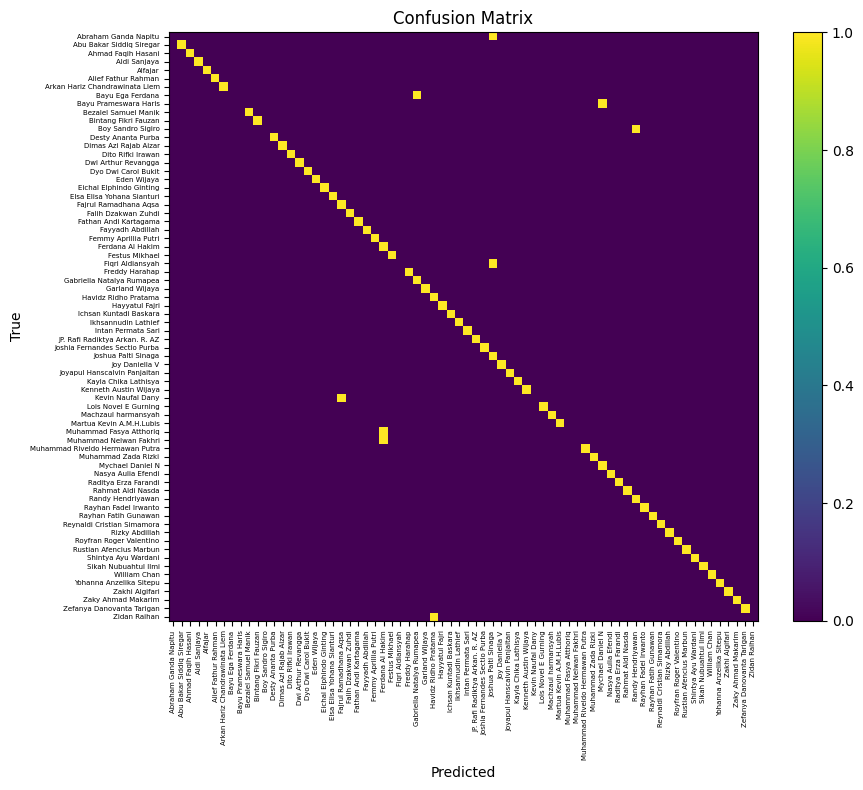


Classification Report (70 kelas, yg kosong akan 0):
                                 precision    recall  f1-score   support

           Abraham Ganda Napitu     0.0000    0.0000    0.0000         1
       Abu Bakar Siddiq Siregar     1.0000    1.0000    1.0000         1
             Ahmad Faqih Hasani     1.0000    1.0000    1.0000         1
                   Aldi Sanjaya     1.0000    1.0000    1.0000         1
                        Alfajar     1.0000    1.0000    1.0000         1
            Alief Fathur Rahman     1.0000    1.0000    1.0000         1
 Arkan Hariz Chandrawinata Liem     1.0000    1.0000    1.0000         1
               Bayu Ega Ferdana     0.0000    0.0000    0.0000         1
          Bayu Prameswara Haris     0.0000    0.0000    0.0000         1
           Bezalel Samuel Manik     1.0000    1.0000    1.0000         1
           Bintang Fikri Fauzan     1.0000    1.0000    1.0000         1
              Boy Sandro Sigiro     0.0000    0.0000    0.0000        

In [31]:
# =========================
# 9. EVALUASI LENGKAP (CONFUSION MATRIX, PRECISION, RECALL, F1)
# =========================

def evaluate_with_metrics(model, loader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    num_classes = len(class_names)
    all_label_ids = np.arange(num_classes)  # 0..69 → paksa 70 kelas

    print(f"Total kelas (class_names): {num_classes}")
    print(f"Kelas yang muncul di val : {np.unique(all_labels)}")

    # =========================
    # 1) CONFUSION MATRIX 70x70
    # =========================
    cm = confusion_matrix(
        all_labels,
        all_preds,
        labels=all_label_ids
    )

    print("Confusion Matrix (raw counts):")
    print(cm)
    print(f"Shape of confusion matrix: {cm.shape}")  # harus (70, 70)

    plt.figure(figsize=(10, 8))
    im = plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, class_names, rotation=90, fontsize=5)
    plt.yticks(tick_marks, class_names, fontsize=5)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # =========================
    # 2) CLASSIFICATION REPORT
    # =========================
    print("\nClassification Report (70 kelas, yg kosong akan 0):")
    print(classification_report(
        all_labels,
        all_preds,
        labels=all_label_ids,
        target_names=class_names,
        digits=4,
        zero_division=0
    ))

    # =========================
    # 3) METRIK GLOBAL
    # =========================
    acc = accuracy_score(all_labels, all_preds)

    prec_macro = precision_score(
        all_labels, all_preds,
        labels=all_label_ids,
        average='macro',
        zero_division=0
    )
    rec_macro = recall_score(
        all_labels, all_preds,
        labels=all_label_ids,
        average='macro',
        zero_division=0
    )
    f1_macro = f1_score(
        all_labels, all_preds,
        labels=all_label_ids,
        average='macro',
        zero_division=0
    )

    prec_weighted = precision_score(
        all_labels, all_preds,
        labels=all_label_ids,
        average='weighted',
        zero_division=0
    )
    rec_weighted = recall_score(
        all_labels, all_preds,
        labels=all_label_ids,
        average='weighted',
        zero_division=0
    )
    f1_weighted = f1_score(
        all_labels, all_preds,
        labels=all_label_ids,
        average='weighted',
        zero_division=0
    )

    print(f"\nAccuracy     : {acc:.4f}")
    print(f"Macro Avg   - Precision: {prec_macro:.4f}, Recall: {rec_macro:.4f}, F1: {f1_macro:.4f}")
    print(f"Weighted Avg- Precision: {prec_weighted:.4f}, Recall: {rec_weighted:.4f}, F1: {f1_weighted:.4f}")

    metrics_summary = {
        "accuracy": acc,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        "precision_weighted": prec_weighted,
        "recall_weighted": rec_weighted,
        "f1_weighted": f1_weighted,
    }

    return cm, metrics_summary

cm, metrics = evaluate_with_metrics(model, val_loader, class_names, device)

In [34]:

# =========================
# 10. SAVE MODEL TERBAIK
# =========================

save_path = "8714InceptionResnet_best.pth"
torch.save({
    "model_state_dict": model.state_dict(),
    "num_classes": num_classes,
    "class_names": class_names,
}, save_path)

print(f"Model terbaik disimpan ke: {save_path}")


Model terbaik disimpan ke: 8714InceptionResnet_best.pth


In [33]:
# # ============================================================
# # MASSIVE HYPERPARAMETER TUNING (RANDOM SEARCH)
# # ============================================================
# import itertools
# import pandas as pd
# import random
# import time
# from facenet_pytorch import InceptionResnetV1
# import torch.optim as optim

# # 1. DEFINISI RUANG PENCARIAN (SEARCH SPACE)
# # Kita masukkan semua kemungkinan yang ingin dicoba di sini
# param_grid = {
#     'optimizer_type': ['adamw', 'sgd', 'rmsprop'],  # Jenis Optimizer
#     'lr_backbone':    [1e-6, 1e-5, 1e-4],           # Kecepatan belajar otak
#     'lr_head':        [1e-4, 1e-3, 5e-3],           # Kecepatan belajar classifier
#     'dropout':        [0.4, 0.5, 0.6],              # Tingkat 'lupa' biar ga overfitting
#     'scheduler':      ['cosine', 'step'],           # Cara menurunkan LR
#     'unfreeze_blocks':['last_only', 'last_two']     # Seberapa banyak otak yang dicairkan
# }

# # Membuat semua kombinasi (Grid)
# keys, values = zip(*param_grid.items())
# all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# # Agar tidak menunggu selamanya, kita acak dan ambil sampel saja
# # Total kombinasi ada ratusan. Kita ambil misal 20 kombinasi acak.
# # Ubah N_EXPERIMENTS kalau mau coba lebih banyak.
# N_EXPERIMENTS = 300
# random.shuffle(all_combinations)
# selected_experiments = all_combinations[:N_EXPERIMENTS]

# print(f"Total Kombinasi Mungkin: {len(all_combinations)}")
# print(f"Akan menjalankan: {N_EXPERIMENTS} eksperimen acak.")
# print("="*60)

# # Tempat simpan hasil
# results_log = []

# # --- FUNGSI BUILD MODEL & OPTIMIZER ---
# def build_model_and_optimizer(config, device):
#     # 1. Model
#     model = InceptionResnetV1(
#         pretrained='vggface2',
#         classify=True,
#         num_classes=num_classes,
#         dropout_prob=config['dropout']
#     )

#     # 2. Freeze/Unfreeze Logic
#     for name, param in model.named_parameters():
#         param.requires_grad = False # Freeze All First

#         if "logits" in name: # Classifier selalu aktif
#             param.requires_grad = True

#         # Logika Unfreeze Backbone
#         if config['unfreeze_blocks'] == 'last_only':
#             if "mixed_7a" in name or "repeat_3" in name:
#                 param.requires_grad = True
#         elif config['unfreeze_blocks'] == 'last_two':
#             if "mixed_6a" in name or "repeat_2" in name or "mixed_7a" in name or "repeat_3" in name:
#                 param.requires_grad = True

#     model = model.to(device)

#     # 3. Optimizer Params
#     backbone_params = [p for n, p in model.named_parameters() if "logits" not in n and p.requires_grad]
#     head_params = [p for n, p in model.named_parameters() if "logits" in n and p.requires_grad]

#     optim_params = [
#         {'params': backbone_params, 'lr': config['lr_backbone']},
#         {'params': head_params, 'lr': config['lr_head']}
#     ]

#     # Pilih Optimizer
#     if config['optimizer_type'] == 'adamw':
#         optimizer = optim.AdamW(optim_params, weight_decay=1e-3)
#     elif config['optimizer_type'] == 'sgd':
#         optimizer = optim.SGD(optim_params, momentum=0.9, weight_decay=1e-3)
#     elif config['optimizer_type'] == 'rmsprop':
#         optimizer = optim.RMSprop(optim_params, momentum=0.9, weight_decay=1e-3)

#     # Pilih Scheduler
#     if config['scheduler'] == 'cosine':
#         scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
#     else:
#         scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

#     return model, optimizer, scheduler

# # --- LOOP EKSPERIMEN ---
# for i, config in enumerate(selected_experiments):
#     print(f"\n🧪 [Eksperimen {i+1}/{N_EXPERIMENTS}]")
#     print(f"   Opt: {config['optimizer_type']} | LR_Back: {config['lr_backbone']} | LR_Head: {config['lr_head']}")
#     print(f"   Drop: {config['dropout']} | Sch: {config['scheduler']} | Unfreeze: {config['unfreeze_blocks']}")

#     # Init Model Baru
#     model_tmp, opt_tmp, sch_tmp = build_model_and_optimizer(config, device)
#     criterion_tmp = nn.CrossEntropyLoss(label_smoothing=0.1)

#     # Train Singkat (Hanya 16 Epoch untuk screening)
#     # Kalau bagus di 16 epoch, biasanya bagus seterusnya.
#     best_acc_this_run = 0.0

#     start_time = time.time()
#     for ep in range(16):
#         # Train
#         model_tmp.train()
#         for imgs, labels in train_loader:
#             imgs, labels = imgs.to(device), labels.to(device)
#             opt_tmp.zero_grad()
#             outputs = model_tmp(imgs)
#             loss = criterion_tmp(outputs, labels)
#             loss.backward()
#             opt_tmp.step()

#         sch_tmp.step()

#         # Validate
#         if (ep+1) % 2 == 0: # Cek validasi tiap 2 epoch biar cepet
#             _, val_acc = validate(model_tmp, val_loader, criterion_tmp, device)
#             if val_acc > best_acc_this_run:
#                 best_acc_this_run = val_acc
#             print(f"      Ep {ep+1}: Val Acc = {val_acc:.4f}", end="\r")

#     elapsed = time.time() - start_time
#     print(f"\n   ✅ Hasil: Best Acc = {best_acc_this_run:.4f} (Waktu: {elapsed:.1f}s)")

#     # Simpan log
#     log_entry = config.copy()
#     log_entry['best_accuracy'] = best_acc_this_run
#     results_log.append(log_entry)

# # --- MENAMPILKAN HASIL TERBAIK ---
# print("\n" + "="*60)
# print("🏆 KESIMPULAN HASIL TUNING (Diurutkan dari Terbaik)")
# print("="*60)

# df_results = pd.DataFrame(results_log)
# # Urutkan berdasarkan akurasi tertinggi
# df_sorted = df_results.sort_values(by='best_accuracy', ascending=False)

# # Tampilkan 10 terbaik
# print(df_sorted.head(10).to_string(index=False))

# # Ambil config terbaik untuk dipakai
# best_config = df_sorted.iloc[0].to_dict()
# print(f"\n✨ Konfigurasi Pemenang: {best_config}")